In [16]:
!pip install /home/centos/phs/X_rayAbnormalitiesDetection/vgb-lib/timm-0.1.26-py3-none-any.whl
!tar xfz /home/centos/phs/X_rayAbnormalitiesDetection/vgb-lib/pkgs.tgz
# for pytorch1.6
cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
!$cmd

Processing ./vgb-lib/timm-0.1.26-py3-none-any.whl
timm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [25]:
!pip install timm==0.4.12
!pip install --upgrade pip


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.0 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 22.1.2
    Uninstalling pip-22.1.2:
      Successfully uninstalled pip-22.1.2


In [27]:
import sys
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pandas as pd
from tqdm import tqdm

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [28]:
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "omegaconf")

In [ ]:
args = {
    'TRAIN_DATA' : '/home/centos/phs/X_rayAbnormalitiesDetection/input_x_ray2/train',
}

In [30]:
train = pd.read_csv('/home/centos/phs/X_rayAbnormalitiesDetection/input_x_ray/train.csv')
train = train.loc[train['class_id']!=14]
train.shape

(36096, 8)

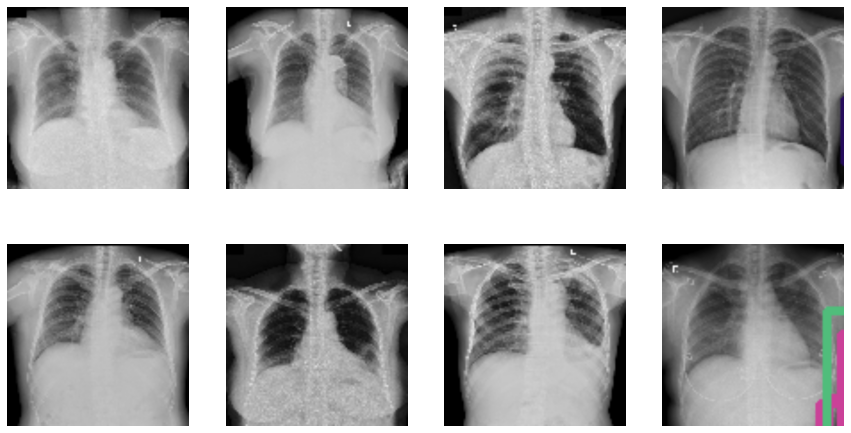

In [89]:
imgs = []
img_ids = train['image_id'].values
class_ids = train['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}
scale = 5

fig , axes = plt.subplots(2,4)
fig.set_size_inches(15,8)

for index in range(8):
    img_id = random.choice(img_ids)
    img_path = f'{args["TRAIN_DATA"]}/{img_id}.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    boxes = train.loc[train['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values/scale
    labels = train.loc[train['image_id'] == img_id, ['class_id']].values.squeeze()
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id]
        img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 3)
        
    img = cv2.resize(img, (500,500))
    
    axes[index//4 , index%4].imshow(img)
    axes[index//4,  index%4].axis('off')

In [90]:
class VinBigDataset(Dataset):
    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()
        self.marking = marking
        self.image_ids = image_ids
        self.transforms = transforms
        self.test = test
        
    def __len__(self):
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f"{args['TRAIN_DATA']}/{image_id}.jpg", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image / 255.0
        
        records = self.marking[self.marking['image_id']==image_id]
        boxes = records[['x_min','y_min','x_max','y_max']].values
        labels = records['class_id'].values
        
        return image, boxes, labels
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        target = {'boxes':boxes, 'labels': torch.tensor(labels)}
        
        if self.transforms:
            sample = {'image' : image, 'bboxes' : boxes, 'labels' : labels}
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(sample['bboxes'])))).squeeze(1)
            
        target['boxes'][:,[0,1,2,3]] = target['boxes'][:, [1,0,3,2]]
        
        return image, target, image_id


In [91]:
random_seed= 42

image_names = np.random.permutation(train['image_id'].unique())

val_len = int(len(image_names)*0.2)

images_train = image_names[:-val_len]
images_valid = image_names[-val_len:]
print(len(images_train), len(images_valid))

3516 878


In [92]:
def get_train_transforms():
    return A.Compose([A.Resize(512,512),
                      A.Flip(0.5),
                      ToTensorV2()], 
                     bbox_params=A.BboxParams(format='pascal_voc', 
                                              label_fields=['labels']))

def get_valid_transforms():
    return A.Compose([A.Resize(512,512),
                      ToTensorV2()], 
                     bbox_params=A.BboxParams(format='pascal_voc', 
                                              label_fields=['labels']))


In [93]:
train_set = VinBigDataset(train, images_train,transforms=get_train_transforms(), test=False)
valid_set = VinBigDataset(train, images_valid, transforms=get_valid_transforms(), test=True)

In [94]:
class Fitter:
    def __init__(self, model, device, config):
        self.model = model
        self.device = device
        self.config = config
        self.epoch = 0
        self.base_dir = f"./{config.folder}"
        
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f"{self.base_dir}/log.txt"
        self.best_summary_loss = 10**5
        self.param_optimizer = list(self.model.named_parameters())
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr = config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f"device is {self.device}")

    def fit(self, train_loader, valid_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f"시간 : {timestamp}, Learning Rate : {lr}")
            
            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}') # loss 평균   
            self.save(f"{self.base_dir}/last-checkpoint.bin")
            
            t = time.time()
            summary_loss = self.validation(valid_loader)
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
            
                try:
                    os.remove(f)
                except:
                    pass
                
                f = f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin'

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)
            
            self.epoch+=1
                
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(f"Val Step : {step}/{len(val_loader)}, " + \
                          f"summary_loss : {summary_loss.avg:.5f}, " + \
                          f"time : {(time.time() - t):.5f}", end="\r"
                         )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [x['boxes'].to(self.device).float() for x in targets]
                labels = [x['labels'].to(self.device).float() for x in targets]
                
                loss, _, _ = self.model(images, boxes, labels)
                
                summary_loss.update(loss.detach().item(), batch_size)
        return summary_loss
                    
    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(f"Train Step : {step}/{len(train_loader)}, " + \
                          f"summary_loss : {summary_loss.avg:.5f}, " + \
                          f"time : {(time.time() - t):.5f}", end="\r"
                         )
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [x['boxes'].to(self.device).float() for x in targets]
            labels = [x['labels'].to(self.device).float() for x in targets]
            
            self.optimizer.zero_grad()
            loss, _, _ = self.model(images, boxes, labels)
            loss.backward()
            summary_loss.update(loss.detach().item(), batch_size)
            self.optimizer.step()
            
            if self.config.step_scheduler:
                self.scheduler.step()
        
        return summary_loss            
        
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict' : self.model.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict(),
            'scheduler_state_dict' : self.scheduler.state_dict(),
            'best_summary_loss' : self.best_summary_loss,
            'epoch' : self.epoch
        }, path)
        
    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [95]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [96]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4 
    n_epochs = 20
    lr = 0.0002
    folder = 'effdet5-models'
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=5,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [97]:
def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_set),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        valid_set, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(valid_set),
        pin_memory=False,
        collate_fn=collate_fn,
    )
    
    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

def collate_fn(batch):
    return tuple(zip(*batch))